In [3]:
import tensorflow as tf 
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version: "+tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
Tensorflow version: 2.15.0


In [4]:
import sys
import tensorflow.keras
import tensorflow as tf
import numpy as np

print(f"Tensor Flow Version: {tf.__version__}")
print()
print(f"Python {sys.version}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.15.0

Python 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
GPU is available


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


& �tait inattendu.


In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
from sklearn.utils import Bunch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.applications.vgg16 import VGG16
from tensorflow import keras
from keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv1D
from keras import regularizers



In [12]:
def getProfilSD(profil):
    #Générer des données aléatoires pour le nuage de points
    num_points = len(profil)
    x_values = profil.x
    y_values = profil.y

    # # Créer le nuage de points
    # plt.scatter(x_values, y_values, c='blue', marker='o', label='Nuage de points')

    # Effectuer la régression linéaire
    coefficients = np.polyfit(x_values, y_values, 1)
    polynomial = np.poly1d(coefficients)

    # Tracer la droite de régression linéaire
    x_regression = np.linspace(min(x_values), max(x_values), num_points)

    residuals = y_values -  polynomial(x_regression)
    return np.std(residuals)
                     
def shiftYValues(profil):
    zone1 = profil[(profil.x >= -570) & (profil.x <= -470)]
    zone3 = profil[(profil.x >= 470) & (profil.x <= 570)]

    sd_zone1 = getProfilSD(zone1) if not zone1.empty else None
    sd_zone3 = getProfilSD(zone3) if not zone3.empty else None

    if(sd_zone1 == None):
        xmin = zone3.x.min()
    elif(sd_zone3 == None):
        xmin = zone1.x.min()
    else : 
        xmin = zone3.x.min() if sd_zone3 < sd_zone1 else zone1.x.min()
        
    # print(f"xmin : {xmin} ymin : {profil[profil.x == xmin].y.values[0]}" )
    profil['y'] -= profil.loc[profil['x'] == xmin, 'y'].values[0]
    profil = profil[(profil.x >= -470) & (profil.x <= 470)]
    return profil

# Function to remove outlier from y 
def remove_outliers_from_y(points, min_threshold, max_threshold):
    points.loc[(points.y >= max_threshold) | (points.y <= min_threshold), 'y'] = np.nan
    # outlier_mask = points[(points.y >= max_threshold) | (points.y <= min_threshold)] 
    points.loc[:, 'y'] = points.loc[:, 'y'].ffill()
    points.loc[:, 'y'] = points.loc[:, 'y'].bfill()
    return points

def process_normalization(profil, min, max):
    profil['y'] = (profil.y - min) / (max - min)


# Function to standardize the size of data by adding padding
def pad_to_same_size(data):
    # permet de mettre toutes les données à la même taille.     
       
    max_length = max(len(d) for d in data)
    return [tf.pad(d, paddings=[[0, max_length - len(d)]], mode='SYMMETRIC') if len(d) < max_length else d for d in data]

# Function to process each CSV file
def process_csv_file(file_path):
    min_y = -110
    max_y = 200 
    points = pd.read_csv(file_path, names=['x', 'y'])
    sorted_points = points.sort_values(by='x')
    sorted_points = sorted_points.drop_duplicates()
    # shifted_points = shiftYValues(sorted_points)
    # cleaned_points = remove_outliers_from_y(shifted_points,min_y,max_y)
    sorted_points = sorted_points[(sorted_points.x >= -470) & (sorted_points.x <= 470)]
    sorted_points.y +=1200
    sorted_points.y /=10
    
    # process_normalization(cleaned_points,min_y,max_y)
    return sorted_points.y

def load_profiles(src):
    classes_id = [d for d in os.listdir(src) if os.path.isdir(os.path.join(src, d))]
    data = []
    target = []
    for classe_id in classes_id:
        dataset_path = os.path.join(src,classe_id)
        files_path = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith('.csv')]
        for file_path  in files_path: 
            profil_points = process_csv_file(file_path)
            data.append(profil_points)
            target.append(classe_id)
    
    padded_data = pad_to_same_size(data)
    return  Bunch(
         data= np.array(padded_data), 
         target= np.array(target) )


In [15]:
dataset_root = "/mnt/c/Users/onerf/Documents/UMons/Master2/Test/src/db/"

profiles = load_profiles(dataset_root + "sleepers_db/")
profiles_test = load_profiles(dataset_root + "test/")

id2int = {v:ix for ix,v in enumerate(np.unique(profiles.target))}
int2id = {v:ix for ix,v in enumerate(np.unique(profiles.target))}

profiles.target = [id2int[val] for val in profiles.target]
profiles_test.target = [id2int[val] for val in profiles_test.target]

2024-02-16 19:26:28.584136: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-16 19:26:28.584216: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-16 19:26:28.584248: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-16 19:26:28.787926: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-16 19:26:28.787979: I external/local_xla/xla/stream_executor

In [16]:
x, y = profiles.data, profiles.target
x = x.reshape(x.shape[0],x.shape[1],1)
print(f'x shape : {x.shape}')
x_test, y_test = profiles_test.data, profiles_test.target
x_test= x_test.reshape(x_test.shape[0],x_test.shape[1],1)
print(f'x_test shape : {x_test.shape}')

x shape : (2220, 437, 1)
x_test shape : (400, 437, 1)


In [17]:
def get_model():
    model = Sequential()
    model.add(keras.layers.Conv1D(16,9, activation='relu', input_shape=(437, 1)))
    # model.add(keras.layers.Conv1D(16,16, activation='relu', input_shape=(437, 1)))
    # model.add(keras.layers.Dropout(0.2))
    # model.add(keras.layers.MaxPooling1D(pool_size=6,padding="valid"))
    model.add(Flatten())  # Flatten the output from the convolutional layer
    # model.add(keras.layers.Dense(units=256, activation='sigmoid')) 
    # model.add(Flatten()) # Assuming 3 classes, adjust based on your task
    model.add(keras.layers.Dense(units=3, activation='softmax'))  # Assuming 3 classes, adjust based on your task
    return model


In [18]:
batch_sizes = [16,32] 
n_epochs= [100] 
dict = {}
for batch_size in batch_sizes:
    dict[batch_size]= {}
    for epoch in n_epochs:
        model = get_model()
        model.compile(optimizer=SGD(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(x, np.array(y), epochs=epoch, validation_split=0.2, shuffle=True, batch_size=batch_size)
        eval = model.evaluate(x_test,np.array(y_test))
        dict[batch_size][epoch] = [history,eval]

Epoch 1/100


2024-02-16 19:27:31.902995: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-16 19:27:32.319467: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-16 19:27:33.131185: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-16 19:27:33.311645: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc97ec24810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-16 19:27:33.311693: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
I0000 00:00:1708108053.411929    3171 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


111/111 [==============================] - 4s 10ms/step - loss: 0.9351 - accuracy: 0.5771 - val_loss: 1.5400 - val_accuracy: 0.0203
Epoch 2/100
111/111 [==============================] - 1s 7ms/step - loss: 0.8518 - accuracy: 0.6250 - val_loss: 1.6505 - val_accuracy: 0.0158
Epoch 3/100
111/111 [==============================] - 1s 6ms/step - loss: 0.8032 - accuracy: 0.6593 - val_loss: 1.5331 - val_accuracy: 0.0248
Epoch 4/100
111/111 [==============================] - 1s 6ms/step - loss: 0.7536 - accuracy: 0.6898 - val_loss: 1.4714 - val_accuracy: 0.0270
Epoch 5/100
111/111 [==============================] - 1s 6ms/step - loss: 0.7236 - accuracy: 0.7050 - val_loss: 1.5192 - val_accuracy: 0.0248
Epoch 6/100
111/111 [==============================] - 1s 6ms/step - loss: 0.6899 - accuracy: 0.7292 - val_loss: 1.4755 - val_accuracy: 0.0360
Epoch 7/100
111/111 [==============================] - 1s 6ms/step - loss: 0.6650 - accuracy: 0.7382 - val_loss: 1.4791 - val_accuracy: 0.0383
Epoch 8/10

KeyboardInterrupt: 

In [84]:
model.summary()

Model: "sequential_145"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_183 (Conv1D)         (None, 422, 16)           272       
                                                                 
 conv1d_184 (Conv1D)         (None, 407, 16)           4112      
                                                                 
 dropout_2 (Dropout)         (None, 407, 16)           0         
                                                                 
 max_pooling1d_38 (MaxPooli  (None, 67, 16)            0         
 ng1D)                                                           
                                                                 
 flatten_182 (Flatten)       (None, 1072)              0         
                                                                 
 dense_182 (Dense)           (None, 256)               274688    
                                                    

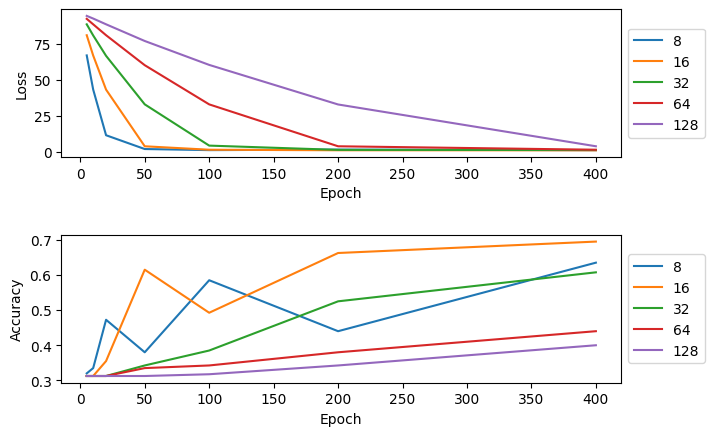

In [73]:
fig, ax = plt.subplots(2,1, figsize=(7,5))
fig.tight_layout(pad=3.5)
for batch_size in dict.keys():
    
    keys = list(dict[batch_size].keys())
    loss_elements = [value[1][0] for value in dict[batch_size].values()]
    accuracy_elements = [value[1][1] for value in dict[batch_size].values()]

    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].plot(keys, loss_elements, label=f'{batch_size}')
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
  
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].plot(keys, accuracy_elements, label=f'{batch_size}')
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


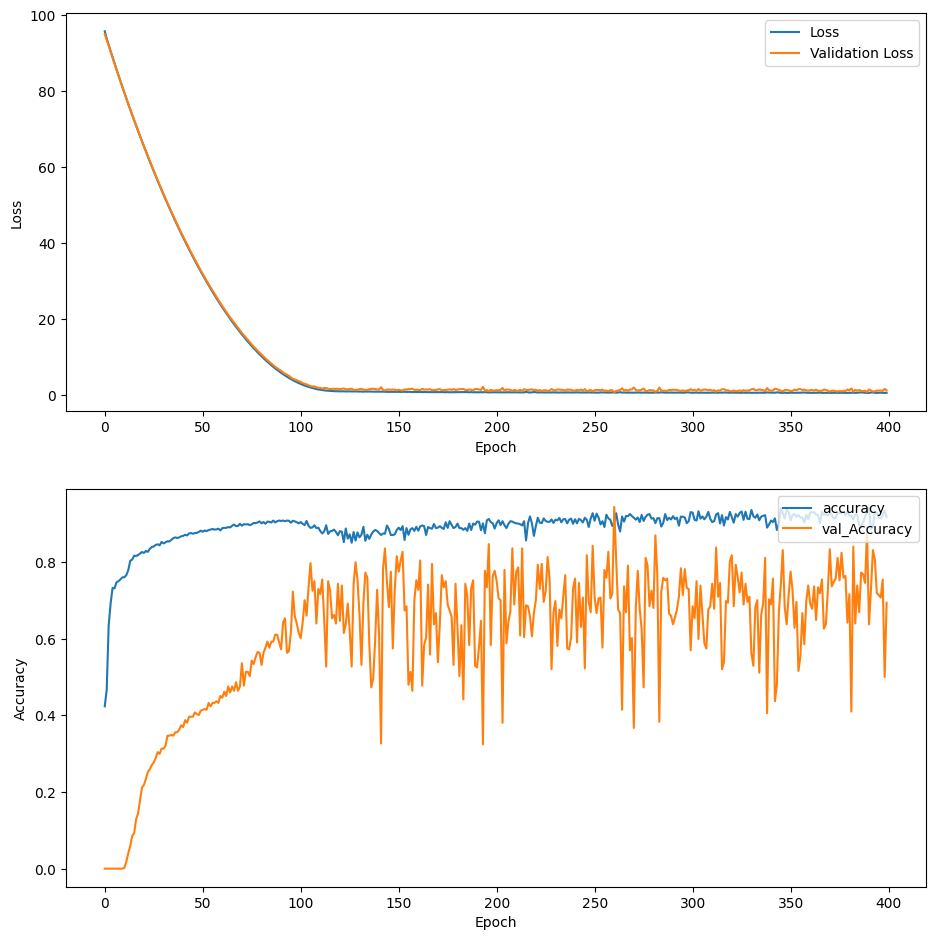

In [78]:
fig, ax = plt.subplots(2, figsize=(10,10))
fig.tight_layout(pad=3.5)
batch_size_ = 32
for idx, epoch in enumerate([400]):

    keys = list(dict.keys())
    loss = dict[batch_size_][epoch][0].history['loss']
    val_loss = dict[batch_size_][epoch][0].history['val_loss'] 
    accuracy = dict[batch_size_][epoch][0].history['accuracy'] 
    val_accuracy = dict[batch_size_][epoch][0].history['val_accuracy'] 


    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].plot(loss, label='Loss')
    ax[0].plot(val_loss, label='Validation Loss')
    ax[0].legend(loc='upper right')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].plot(accuracy, label='accuracy')
    ax[1].plot(val_accuracy, label='val_Accuracy')
    ax[1].legend(loc='upper right'),

In [76]:
new_dict= {}
for batch_size in dict.keys():
    new_dict[batch_size] = {}
    for epoch in dict[batch_size].keys():
        new_dict[batch_size][epoch] = dict[batch_size][epoch][1][1]

df_loss = pd.DataFrame(new_dict)
df_loss.to_csv("Accuracy_method5_with_normalisation.csv",sep=";",decimal= ",")

In [60]:
dict

{8: {5: [<keras.src.callbacks.History at 0x2b8ce0c8bd0>,
   [1.2562426328659058, 0.4350000023841858]],
  10: [<keras.src.callbacks.History at 0x2b8c6948b10>,
   [0.9886651039123535, 0.5299999713897705]],
  20: [<keras.src.callbacks.History at 0x2b8c696e9d0>,
   [0.7863083481788635, 0.6399999856948853]],
  50: [<keras.src.callbacks.History at 0x2b8c5e6b650>,
   [1.0379116535186768, 0.5799999833106995]],
  100: [<keras.src.callbacks.History at 0x2b8c5e1fed0>,
   [1.0240943431854248, 0.6274999976158142]],
  200: [<keras.src.callbacks.History at 0x2b8c5987f10>,
   [1.1271653175354004, 0.6600000262260437]],
  400: [<keras.src.callbacks.History at 0x2b8b50f7ad0>,
   [1.1635091304779053, 0.7749999761581421]]},
 16: {5: [<keras.src.callbacks.History at 0x2b8ecfe6210>,
   [1.1951779127120972, 0.41749998927116394]],
  10: [<keras.src.callbacks.History at 0x2b8d1144950>,
   [1.1939507722854614, 0.4625000059604645]],
  20: [<keras.src.callbacks.History at 0x2b8cf7bec10>,
   [0.6695060133934021, 0.

In [ ]:
model = get_model()
model.compile(optimizer=SGD(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x, np.array(y), epochs=200, validation_split=0.2, shuffle=True, batch_size=128)
eval = model.evaluate(x_test,np.array(y_test))
# Visualisation des courbes d'entraînement/validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
